In [3]:
import os, sys

dtype = "float32"
MAIN = "/Users/abidaurrazaga/Desktop/PhD/StructuralRBM"
nb_path = '/Users/abidaurrazaga/Desktop/PhD/StructuralRBM/Modules'
sys.path.append(nb_path)

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from math import floor,log10

import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.class_weight import compute_sample_weight

import Launch_Experiments

PARAMS_DICT = Launch_Experiments.PARAMS_DICT

CORRUPTIONS = Launch_Experiments.CORRUPTIONS

METRICS_DICT = Launch_Experiments.METRICS_DICT

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Lucida"]})

# Confusion matrix

In [4]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import seaborn as sn
def plotConfusionMatrix(TrueClass,PredictedClass,**kwargs):
    TrueClass,PredictedClass = ProcessClasses(TrueClass),ProcessClasses(PredictedClass)
    plt.figure(figsize = (15,10))
    sn.heatmap(confusion_matrix(TrueClass,PredictedClass),annot=True)
    plt.title(kwargs.get("title",""))
    plt.savefig(os.path.join(MAIN,"Images","Confusion "+kwargs.get("title","")))
    plt.show()

def ProcessClasses(oneHotClass):
    try:
        nClasses = len(oneHotClass[0])
        enc = OneHotEncoder(sparse = False)
        enc.fit(np.array([i for i in range(nClasses)]).reshape(-1,1))
        return enc.inverse_transform(oneHotClass)[:,0]
    except:
        return oneHotClass

def modelAcronym(model):
    file_name = model.get_name()
    if "window" in file_name:
        acronym = "SBM "
    else:
        acronym = "RBM "
    return acronym+str(model.n_hidden)

def modelConfusionMatrix(model,TrueClass,Images,**kwargs):
    PredictedProbs = model.predict(Images)
    PredictedClass = Classify(PredictedProbs)
    plotConfusionMatrix(TrueClass,PredictedClass,title=modelAcronym(model))

def Classify(PredictedProbs):
    return tf.one_hot(tf.math.argmax(PredictedProbs,axis = 1),depth = len(PredictedProbs[0]))

In [ ]:
modelNames = [m[1] for m in model_iterable(DATA_NAME = "MNIST",TASK="Supervised",lr = 0.01,momentum=0.9,epochs = 5000)]

In [ ]:
from Save_Load import load_rbm,from_dataset_to_array
Images,TrueClass = from_dataset_to_array(data_name = "identity", split = "test")
for modelName in modelNames:
    if "seed_0" in modelName:
        print(modelName)
        Model = load_rbm(modelName,MAIN = MAIN)
        modelConfusionMatrix(Model,TrueClass,Images)

# Dataset class balance

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from Save_Load import from_dataset_to_array
def class_count(one_hot):
    enc = OneHotEncoder(sparse = False,dtype = "float32")
    enc.fit(np.array([i for i in range(one_hot.shape[1])]).reshape(-1,1))
    class_list = enc.inverse_transform(one_hot)
    return class_list
datasets = ["identity","fashion_mnist","breastmnist","pneumoniamnist"]
for dataset in datasets:
    images,label = from_dataset_to_array(dataset,split = "test")
    print("Dataset: %s; Max: %s; Min: %s\n"%(dataset,np.max(images),np.min(images)))
    counts = class_count(label)
    plt.hist(counts)
    plt.title(dataset)
    plt.show()


# Generate Boxplots

In [6]:
from Save_Load import load_rbm,from_dataset_to_array
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score as ROC
from sklearn.metrics import accuracy_score as ACCURACY
from sklearn.metrics import balanced_accuracy_score as BALANCED_ACCURACY
from sklearn.metrics import log_loss
import Launch_Experiments
from RBM import RBM,SBM
from ClassRBM import ClassRBM,ClassSBM 
import seaborn as sn
sn.set(font_scale = 2)
sn.set_palette(sn.color_palette("Set2"))

def model_iterable(**kwargs):
    model_names = []
    model_kwargs = []

    if kwargs.get("all_train_size",False):
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.PARAMS_DICT_3]
    elif kwargs.get("small_model",False):
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.PARAMS_DICT_5]
    elif kwargs.get("new_model",False):
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.new_PARAMS_DICT_1]
    elif kwargs.get("small_train_size",False):
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.PARAMS_DICT_4]
    elif kwargs.get("more_hidden",False):
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.PARAMS_DICT_2]
    else:
        MAIN_DICT = [dict(item,DATA_NAME = kwargs.get("DATA_NAME"), TASK = kwargs.get("TASK")) for item in Launch_Experiments.PARAMS_DICT_1]
    
    DATA_NAME = kwargs.get("DATA_NAME")
    if DATA_NAME == "MNIST":
        _,DATA_LABEL = from_dataset_to_array(data_name = "identity",split = "test")
    elif DATA_NAME == "FashionMNIST":
        _,DATA_LABEL = from_dataset_to_array(data_name = "fashion_mnist",split = "test")
    else:
        _,DATA_LABEL = from_dataset_to_array(data_name = DATA_NAME,split = "test")
    TASK = kwargs.get("TASK")
    if TASK == "Unsupervised":
        method = "LL"
    elif TASK == "Supervised":
        method = "discriminative"
    N_CLASS = DATA_LABEL.shape[1]
    EPOCHS = kwargs.get("epochs",Launch_Experiments.EPOCHS)
    lr = kwargs.get("lr",Launch_Experiments.lr)
    momentum = kwargs.get("momentum",Launch_Experiments.momentum)
    batch_size = Launch_Experiments.batch_size
    for args in MAIN_DICT:
        for seed in range(10):
            TASK = args.get("TASK") # "Unsupervised" or "Supervised"
            DATA_NAME= args.get("DATA_NAME") # "MNIST" or "FashionMNIST"
            n_hidden = args.get("n_hidden",0)
            
            window = args.get("window",0)
            stride = args.get("stride",0)
            
            window_list = args.get("window_list",[])
            stride_list = args.get("stride_list",[])

            n_fold = args.get("n_fold",0)

            train_size = args.get("train_size",0)

            dic = dict(batch_size = batch_size,n_visible = 784,n_hidden = n_hidden, n_class = N_CLASS, train_size = train_size,
                          window = window, stride = stride, window_list = window_list, stride_list = stride_list, n_fold = n_fold, name = "_"+DATA_NAME,
                          epochs = EPOCHS,k_gibbs = 1, MAIN = MAIN,seed = seed, method = method,
                          lr = lr,momentum = momentum, dtype = Launch_Experiments.dtype)
            if TASK == "Unsupervised":
                model = RBM(**dic)
            elif TASK == "Supervised":
                model = classRBM(**dic)
            dic["n_hidden"] = model.n_hidden
            model.batch_size = batch_size
            model.epochs = EPOCHS
            model_kwargs.append(dic)
            model_names.append(model.get_name())

    print("N of models %s"%len(model_names))
    return zip(model_kwargs,model_names)

def obtainClassWeights(Classes):
    return compute_sample_weight("balanced",ProcessClasses(Classes))

def compute_metric(metric,model,test_data,test_data_y,test_corrupted):
    """Computes metrics for train and val set, and adds them to the history of the model"""
    if metric == "roc":
        m = ROC(test_data_y,model.predict(test_data))
    if metric == "accuracy":
        m = ACCURACY(test_data_y,model.sample_class_from_probs(model.predict(test_data)))
    if metric == "balanced_accuracy":
        y_true,y_pred = ProcessClasses(test_data_y),ProcessClasses(model.sample_class_from_probs(model.predict(test_data)))
        m = BALANCED_ACCURACY(y_true,y_pred)
    if metric == "log_loss":
        y_pred = model.predict(test_data)
        if "seed_0" in model.get_name():
            for i in range(test_data_y.shape[0]):
                prob = y_pred[i,np.where(test_data_y[i]==1)]
                if prob<0.2 and False:
                    print(np.where(test_data_y[i]==1))
                    j = np.argmax(y_pred[i])
                    print("Class %s prob %s"%(j,y_pred[i,j]))
                    plt.imshow(test_data[i].reshape((28,28)),cmap = plt.get_cmap('gray'))
                    plt.show()
                #print(model.get_name())
                #(log_loss(test_data_y,y_pred))
                #print("Class %s Prob %s"%(np.where(test_data_y[i]==1),y_pred[i,np.where(test_data_y[i]==1)]))
                #print(test_data_y[0])
                #print(y_pred[0])
        m = log_loss(test_data_y,y_pred,sample_weight=obtainClassWeights(test_data_y))
    if metric == "recon_mse":
        m = float(tf.reduce_mean(model.recon_mse(test_data,test_corrupted)))
    if metric == "LL":
        #model.K = 100
        model.M = 16
        #model.n = 100
        #print("LogZ")
        model.approx_log_Z = model.AIS_log_Z() # ALWAYS compute logZ before computing LL
        #print("LL")
        m = float(model.approximated_LL(test_data))
    if metric == "epoch":
        m = model.epoch+1
    if metric == "time":
        m = model.training_time/60
    if metric == "dW_compute_time":
        m = np.mean(model.dW_compute_time)
    return m 

def df_row_values(model_kwargs,model_name,**kwargs):
    #print(model_name)
    if kwargs.get("extract_epochs"):

        rbm = load_rbm(model_name,**kwargs)
        tempTable = pd.DataFrame(columns = kwargs.get("columns"),index = range(len(rbm.history[list(rbm.history)[0]])))
        if "window" in model_name:
            tempTable["Model"] = "SBM"
        else:
            tempTable["Model"] = "RBM"

        tempTable["N_hidden"] = model_kwargs.get("n_hidden",0)
        tempTable["Train_size"] = model_kwargs.get("train_size",0)
        tempTable["Seed"] = model_kwargs.get("seed")
        tempTable["Epoch"] = range(1,len(rbm.history[list(rbm.history)[0]])+1)

        for metric in kwargs.get("metrics",["train_LL"]):
            tempTable[metric] = rbm.history[metric]

        return tempTable

    elif "Noise" in kwargs.get("metrics",[]):
        values_list = []
        rbm = load_rbm(model_name,**kwargs)
        test_data,_ = from_dataset_to_array(data_name = "identity",split = "test")
        for corruption in Launch_Experiments.CORRUPTIONS:
            values = []
            if "window" in model_name:
                values.append("SBM")
            else:
                values.append("RBM")
            values.append(model_kwargs.get("n_hidden",0))
            values.append(model_kwargs.get("train_size",-1))
            values.append(len(rbm.history[list(rbm.history)[0]]))
            values.append(model_kwargs.get("seed"))
            values.append(corruption)
            test_corrupted,_ = from_dataset_to_array(data_name = corruption,split = "test")
            values.append(compute_metric("recon_mse",rbm,test_data,0,test_corrupted))
            values_list.append(values)
        return values_list
    elif "corrupted_logloss" in kwargs.get("metrics",[]):
        values_list = []
        rbm = load_rbm(model_name,**kwargs)
        test_data,test_label = from_dataset_to_array(data_name = "identity",split = "test")
        for corruption in Launch_Experiments.CORRUPTIONS:
            values = []
            if "window" in model_name:
                values.append("SBM")
            else:
                values.append("RBM")
            values.append(model_kwargs.get("n_hidden",0))
            values.append(model_kwargs.get("train_size",-1))
            values.append(len(rbm.history[list(rbm.history)[0]]))
            values.append(model_kwargs.get("seed"))
            values.append(corruption)
            test_corrupted,_ = from_dataset_to_array(data_name = corruption,split = "test")
            values.append(compute_metric("log_loss",rbm,test_corrupted,test_label,0))
            values_list.append(values)
        return values_list
    else:
        values = []
        if "window" in model_name:
            values.append("SBM")
        else:
            values.append("RBM")
        rbm = load_rbm(model_name,**kwargs)
        values.append(model_kwargs.get("n_hidden",0))
        values.append(model_kwargs.get("train_size",-1))
        values.append(50)#values.append(model_kwargs.get("epoch",len(rbm.history[list(rbm.history)[0]])))
        values.append(model_kwargs.get("seed"))
        
        DATA_NAME = kwargs.get("DATA_NAME")
        if DATA_NAME == "MNIST":
            DATA,DATA_LABEL = from_dataset_to_array(data_name = "identity",split = "test")
        elif DATA_NAME == "FashionMNIST":
            DATA,DATA_LABEL = from_dataset_to_array(data_name = "fashion_mnist",split = "test")
        else:
            DATA,DATA_LABEL = from_dataset_to_array(data_name = DATA_NAME,split = "test")
        test_data = DATA
        test_data_y = DATA_LABEL
        for metric in kwargs.get("metrics",["train_LL"]):
            if metric in rbm.history:
                values.append(float(rbm.history[metric][rbm.opt_ind]))
            else:
                values.append(compute_metric(metric,rbm,test_data,test_data_y,0))
        return values

def df_name(**kwargs):
    name = ""
    if kwargs.get("TASK","Unsupervised") == "Supervised":
        name = "classRBM"
    else:
        name = "RBM"
    name+="_"+kwargs.get("DATA_NAME","MNIST")
    name+="_"+kwargs.get("TASK","Unsupervised")
    name+="_"+"_".join(kwargs.get("metrics",["test_LL"]))
    if kwargs.get("extract_epochs"):
        name+="_all_epochs"
    if kwargs.get("all_train_size"):
        name+="_all_train_size"
    if kwargs.get("small_train_size"):
        name+="_small_train_size"
    if kwargs.get("more_hidden",False):
        name+="_more_hidden"
    return name

def model_exists(model_name,**kwargs):
    file_name = os.path.join(MAIN,kwargs.get("output_dir","Trained RBM/MNIST"),model_name)
    exists = os.path.isfile(file_name)
    if not exists:
        print("%s does not exist"%model_name)
    return exists

def new_df(**kwargs):
    columns = ["Model","N_hidden","Train_size","Epoch","Seed"]
    metrics = kwargs.get("metrics",["test_LL"])
    columns.extend(metrics)
    df = pd.DataFrame(columns=columns)
    i = 0
    for model_kwargs,model_name in model_iterable(**kwargs):
        i+=1
        if i%20==0:
            print(i)
        if model_exists(model_name,**kwargs):
            if kwargs.get("extract_epochs") or "Noise" in kwargs.get("metrics",[]) or "corrupted_logloss" in kwargs.get("metrics",[]):
                df = df.append(df_row_values(model_kwargs,model_name,columns = columns,**kwargs))
            else:
                df.loc[len(df.index)] = df_row_values(model_kwargs,model_name,**kwargs)
    return df

def data_frame(**kwargs):
    file_dir = os.path.join(MAIN,"CSV",df_name(**kwargs))
    if kwargs.get("update",False):
        df = new_df(**kwargs)
        df.to_csv(file_dir)
    else:
        if os.path.isfile(file_dir):
            df = pd.read_csv(file_dir)
        else:
            df = new_df(**kwargs)
            df.to_csv(file_dir)
    return df

# MNIST Denoising mse

In [ ]:
DATA_NAME = "MNIST"
TASK = "Unsupervised"
metric = "Noise"
versus = "N_hidden"
df = data_frame(DATA_NAME = DATA_NAME,metrics = ["Noise","mse"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,epochs=5000,extract_epochs=False,small_train_size = False)
df["mse"] = 100*df["mse"]
df["Denoising mse($10^{-2}$)"] = df["mse"]
ax = sn.catplot(x=versus, y="Denoising mse($10^{-2}$)",col = "Noise",col_wrap=4,

                hue="Model", #col="Train_size",

                data=df, kind="violin",

                height=5, aspect=1.,sharey=False)
#ax.set(ylabel="Denoising mse($10^{-2}$)",fontsize=20)
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(template='{col_name}')
#ax.set(yscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# MNIST Test LL

N of models 100
20
40
60
80
100
N of models 120
RBM_n_hidden_562_FashionMNIST_method_LL_seed_0_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_1_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_2_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_3_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_4_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_5_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_6_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_7_epochs_10000_lr_1_momentum_095_batch_size_16 does not exist
RBM_n_hidden_562_FashionMNIST_method_LL_seed_8_epochs_10000_lr_1_momentum_095_batch_size_16 does

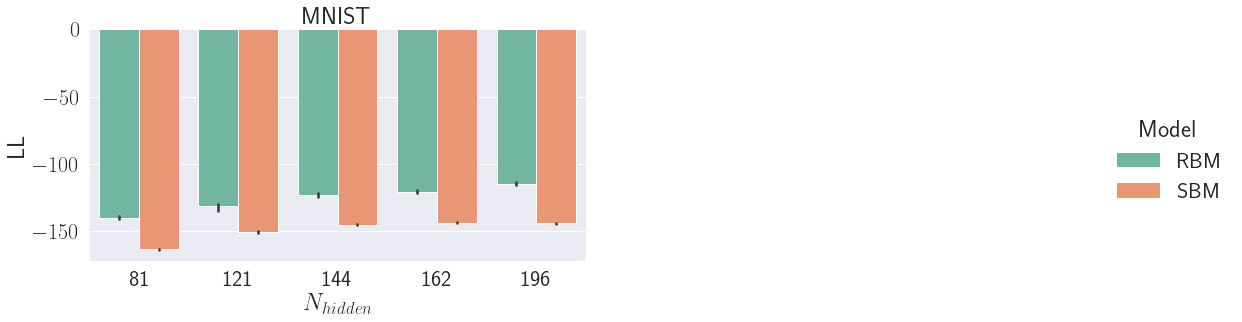

In [71]:
DATA_NAME = "MNIST"
TASK = "Unsupervised"
metric = "LL"
versus = "N_hidden"
UPDATE = 1
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,epochs = 5000,lr=0.01,momentum=0.9,update=UPDATE)
DATA_NAME = "FashionMNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,new_model = 1)
DATA_NAME = "breastmnist"
df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,new_model = 1)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,new_model = 1)
df1["DATA_NAME"] = "MNIST"
df2["DATA_NAME"] = "FashionMNIST"
df3["DATA_NAME"] = "BreastMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df = pd.concat([df1,df2,df4,df3])
df["Log-loss"] = df[metric]


ax = sn.catplot(x=versus, y="LL",

                hue="Model", col="DATA_NAME",

                data=df, kind="bar",col_wrap=2,

                height=5, aspect=1.6,sharey=False)
#ax.set(ylim=[0.5,1])

DATA_NAME = "Many"
#ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

In [ ]:
reduced_df = df[df["Train_size"] == 60000]

columns = ["Model","LL","std"]
DF = pd.DataFrame(columns = columns)
for hidden in reduced_df.N_hidden.unique():
    values = ["RBM_{%s}"%hidden]
    rbm_reduced = reduced_df[reduced_df["Model"]=="RBM"]
    LL_values = rbm_reduced[rbm_reduced["N_hidden"]==hidden]["LL"]
    values.append(np.mean(LL_values))
    values.append(np.std(LL_values))
    DF.loc[len(DF.index)] = values

    values = ["SBM_{%s}"%hidden]
    rbm_reduced = reduced_df[reduced_df["Model"]=="SBM"]
    LL_values = rbm_reduced[rbm_reduced["N_hidden"]==hidden]["LL"]
    values.append(np.mean(LL_values))
    values.append(np.std(LL_values))
    DF.loc[len(DF.index)] = values


# More Hidden(SBM x 5) Logloss MNIST+FashionMNIST+MedMNIST

Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
N of models 20
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 624
Using downloaded and verified file:

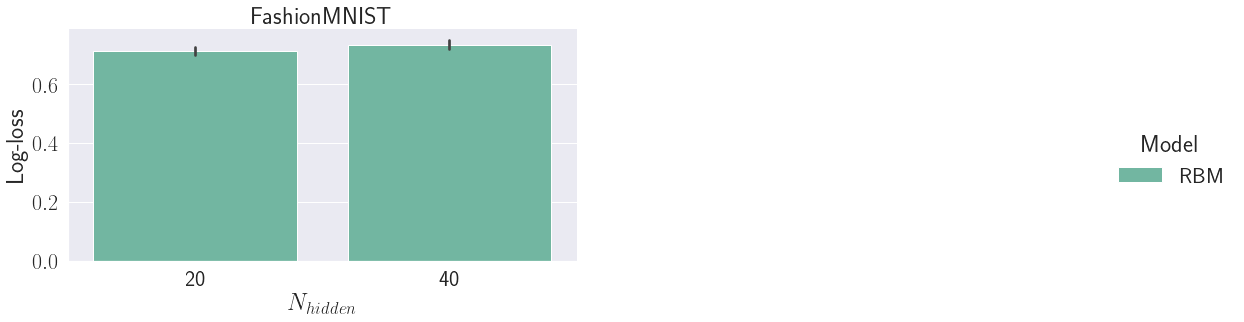

In [98]:
DATA_NAME = "pneumoniamnist"
TASK = "Supervised"
metric = "log_loss"
versus = "N_hidden"
UPDATE = 1
SMALL = 1
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,lr = 0.01,momentum=0.9,small_model=SMALL,epochs = 5000)
DATA_NAME = "FashionMNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,small_model=SMALL,epochs = 5000)
DATA_NAME = "breastmnist"
df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,small_model=SMALL,epochs = 5000)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,small_model=SMALL,epochs = 5000)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
df3["DATA_NAME"] = "BreastMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df = pd.concat([df1,df2,df4,df3])
df["Log-loss"] = df[metric]


ax = sn.catplot(x=versus, y="Log-loss",

                hue="Model", col="DATA_NAME",

                data=df, kind="bar",col_wrap=2,

                height=5, aspect=1.6,sharey=False)
#ax.set(ylim=[0.5,1])

DATA_NAME = "Many"
#ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Log-loss during training

In [ ]:
TASK = "Supervised"
metric = "val_log_loss"
versus = "Epoch"
UPDATE = 0
#df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
DATA_NAME = "MNIST"

df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 10000,extract_epochs=1,small_train_size = 0)
#df1 = df1.rename(columns={"val_LL":"LL"})

DATA_NAME = "FashionMNIST"

#df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#df2 = df2.rename(columns={"val_LL":"LL"})

DATA_NAME = "pneumoniamnist"

#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#df3 = df3.rename(columns={"val_LL":"LL"})

DATA_NAME = "breastmnist"

#df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#df4 = df4.rename(columns={"val_LL":"LL"})
#DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
#DATA_NAME = "pneumoniamnist"
#df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#DATA_NAME = "breastmnist"
#df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#df2["DATA_NAME"] = "FashionMNIST"
df1["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
#df3["DATA_NAME"] = "PneumoniaMNIST"
#df4["DATA_NAME"] = "BreastMNIST"
#df = pd.concat([df1,df2,df3,df4])
#df = df.reset_index()
df = df1
df['N_hidden'] = df['N_hidden'].astype("string")
df["N_hidden"] = "$N_{hidden}=$ "+df["N_hidden"]

col_order = ['$N_{hidden}=$ 196', '$N_{hidden}=$ 162', '$N_{hidden}=$ 121',
 '$N_{hidden}=$ 81']
col_order = col_order[::-1]
ax = sn.relplot(x="Epoch", y=metric,col_order = col_order,hue_order = ["RBM","SBM"],#style="Set",#order=sorted_values,

                hue="Model", col="N_hidden",#row = "DATA_NAME",

                data=df, kind="line", ci=None,#palette="tab10",

                height=7, aspect=1.,facet_kws={'sharey': False, 'sharex': True,"margin_titles":True})

#ax.set(ylim=[0.,0.8])
#ax.set(ylabel="Validation LL")
ax.set(xlabel = "Epoch")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Logloss MNIST+FashionMNIST+MedMNIST

N of models 100
20
40
60
80
100
N of models 100
20
40
60
80
100
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
N of models 100
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 156


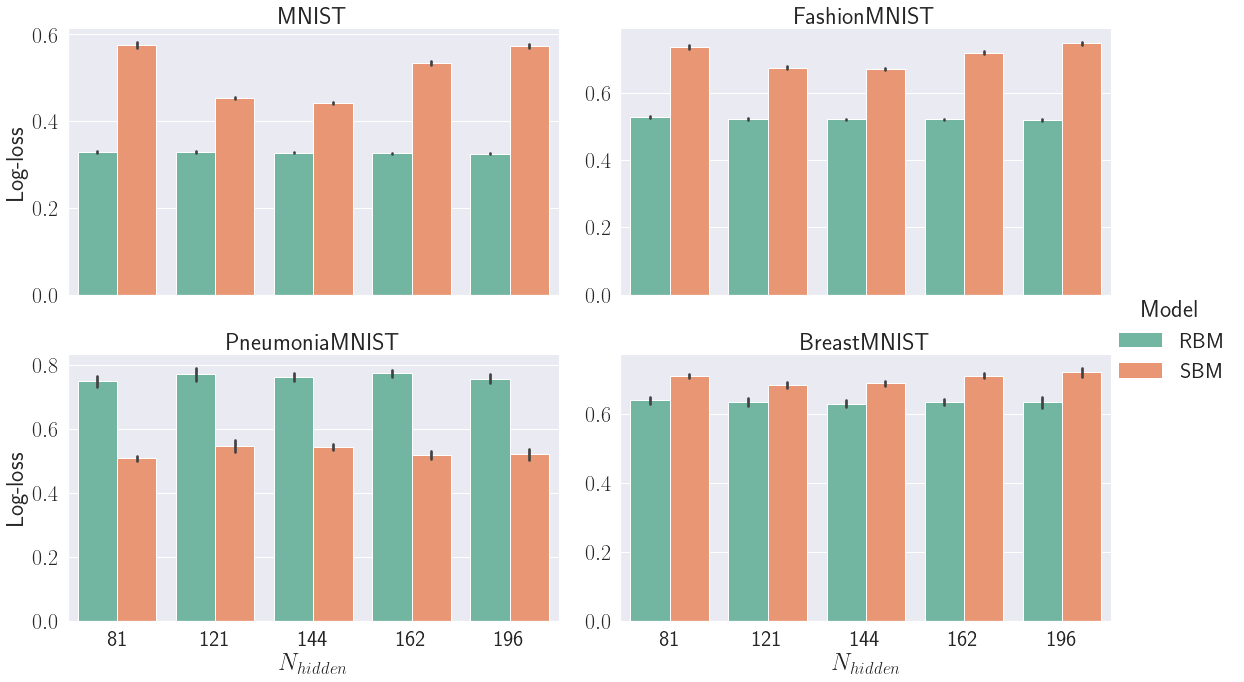

In [99]:
DATA_NAME = "FashionMNIST"
TASK = "Supervised"
metric = "log_loss"
versus = "N_hidden"
UPDATE = 1
EPOCHS = 5000
NEW = 0
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,lr = 0.01,momentum=0.9,update=UPDATE,epochs = EPOCHS,new_model = NEW)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,lr = 0.01,momentum=0.9,update=UPDATE,epochs = EPOCHS,new_model = NEW)
DATA_NAME = "breastmnist"
df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,lr = 0.01,momentum=0.9,update=UPDATE,epochs = EPOCHS,new_model = NEW)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,lr = 0.01,momentum=0.9,update=UPDATE,epochs = EPOCHS,new_model = NEW)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
df3["DATA_NAME"] = "BreastMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df = pd.concat([df2,df1,df4,df3])
df["Log-loss"] = df[metric]


ax = sn.catplot(x=versus, y="Log-loss",hue_order = ["RBM","SBM"],

                hue="Model", col="DATA_NAME",

                data=df, kind="bar",col_wrap=2,

                height=5, aspect=1.6,sharey=False)
#ax.set(ylim=[0.5,1])

DATA_NAME = "Many"
#ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Classification performance

In [ ]:
DATA_NAME = "FashionMNIST"
TASK = "Supervised"
metric = "accuracy"
versus = "N_hidden"
UPDATE = 1
EPOCHS = 5000
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = EPOCHS,new_model = 1)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = EPOCHS,new_model = 1)
DATA_NAME = "breastmnist"
df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = EPOCHS,new_model = 1)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = EPOCHS,new_model = 1)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
df3["DATA_NAME"] = "BreastMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df = pd.concat([df2,df1,df4,df3])
df["Accuracy"] = df[metric]


ax = sn.catplot(x=versus, y="Accuracy",hue_order = ["RBM","SBM"],

                hue="Model", col="DATA_NAME",

                data=df, kind="bar",col_wrap=2,

                height=5, aspect=1.6,sharey=False)
#ax.set(ylim=[0.5,1])

DATA_NAME = "Many"
#ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

In [ ]:
import os
from optparse import OptionParser
__version__ = "1.0"
def command_line_arg():
    """Main function that takes the arguments dataset and task from the terminal"""
    usage = "usage: %prog [options] arg1 arg2"
    par = OptionParser(usage=usage, version= __version__)

    par.add_option('-d', '--dir_name', dest = "dir_name",
            type="str",default = "MNIST")

    return  par.parse_args()
if __name__ == '__main__':
    opts, args = command_line_arg()
    dir_name = opts.dir_name
    M = "/Users/abidaurrazaga/Desktop/PhD/SparseWeightsRBM/Trained RBM/%s"%dir_name
    file_list = os.listdir(M)
    M = "/Users/abidaurrazaga/Desktop/PhD/SparseWeightsRBM/Trained\ RBM/%s"%dir_name
    for file in file_list:
        if not "5000" in file:
            print(file)
            #os.system("rm %s"%os.path.join(M,file))

In [ ]:
DATA_NAME = "FashionMNIST"
TASK = "Supervised"
metric = "log_loss"
versus = "N_hidden"
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=1,extract_epochs=False,small_train_size = False)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=1,extract_epochs=False,small_train_size = False)
DATA_NAME = "pneumoniamnist"
df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=1)#more_hidden=True)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
df3["DATA_NAME"] = "PneumoniaMNIST"
df = pd.concat([df1,df2,df3])


ax = sn.catplot(x=versus, y=metric,sharex=False,

                hue="Model", col="DATA_NAME",

                data=df, kind="bar",

                height=5, aspect=1.6,margin_titles=True)
#ax.set(ylim=[0.5,1])

DATA_NAME = "Many"
ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Classification log-loss on test MNIST+FashionMNIST+MedMNIST (tamaños pequeños)

In [ ]:
DATA_NAME = "FashionMNIST"
TASK = "Supervised"
metric = "log_loss"
versus = "Train_size"
UPDATE = 0
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = True)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = True)
DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "breastmnist"
df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df5["DATA_NAME"] = "BreastMNIST"
df4 = df4[df4["Train_size"]<5000]
df5 = df5[df5["Train_size"]<600]
df = pd.concat([df2,df1,df4,df5])
df["Log-loss"] = df[metric]
df["Train size"] = df["Train_size"]
col_values = df[df["Train_size"]<2000]["Train_size"].unique()
sorted_values = -np.sort(-col_values)[:-1]
col_str = ["$2^{%s}$"%int(np.log(a+0.00001)/np.log(2)) for a in sorted_values]
ax = sn.relplot(x="Train size", y="Log-loss",style="Model",style_order = ["SBM","RBM"],#order=sorted_values,

                hue="N_hidden", col="DATA_NAME",col_wrap=2,

                data=df[df["Train_size"]>0], kind="line", palette="tab10",

                height=5, aspect=1.6,facet_kws={'sharey': False, 'sharex': False})#,margin_titles=True)
#ax.set(ylim=[0.,0.8])
#ax.set(ylabel="Log-loss")
#ax.set(xlabel = "Train size")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
i=0
for axe in ax.axes.flat:
    i+=1
    axe.set_xticks(ticks=sorted_values) # set new labels
    axe.set_xticklabels(labels=sorted_values)
    axe.invert_xaxis()
DATA_NAME = "Many"
#plt.xticks(sorted_values, col_str)
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# LL train size

In [ ]:
DATA_NAME = "FashionMNIST"
TASK = "Unsupervised"
metric = "LL"
versus = "Train_size"
UPDATE = 0
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = True)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = True)
DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "breastmnist"
df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df5["DATA_NAME"] = "BreastMNIST"
df4 = df4[df4["Train_size"]<5000]
df5 = df5[df5["Train_size"]<600]
df = pd.concat([df2,df1,df4,df5])
df["Train size"] = df["Train_size"]
df["Test Loglikelihood"] = df["LL"]
col_values = df[df["Train_size"]<2000]["Train_size"].unique()
sorted_values = -np.sort(-col_values)[:-1]
col_str = ["$2^{%s}$"%int(np.log(a+0.00001)/np.log(2)) for a in sorted_values]
ax = sn.relplot(x="Train size", y="Test Loglikelihood",style="Model",style_order = ["SBM","RBM"],#order=sorted_values,
                hue="N_hidden", col="DATA_NAME",col_wrap=2,

                data=df[df["Train_size"]>0], kind="line", palette="tab10",

                height=5, aspect=1.6,facet_kws={'sharey': False, 'sharex': False})#,margin_titles=True)
#ax.set(ylim=[0.,0.8])
#ax.set(ylabel="Log-loss")
#ax.set(xlabel = "Train size")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
i=0
for axe in ax.axes.flat:
    i+=1
    axe.set_xticks(ticks=sorted_values) # set new labels
    axe.set_xticklabels(labels=sorted_values)
    axe.invert_xaxis()

#plt.xticks(sorted_values, col_str)
#ax.set(xscale="log")
DATA_NAME = "Many"
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# LL on val MNIST (during training)

In [ ]:
TASK = "Unsupervised"
metric = "val_LL"
versus = "Epoch"
UPDATE = 0
#df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
DATA_NAME = "MNIST"

df1 = data_frame(DATA_NAME = DATA_NAME,metrics = ["val_LL"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,new_model=1)
df1 = df1.rename(columns={"val_LL":"LL"})

DATA_NAME = "FashionMNIST"

df2 = data_frame(DATA_NAME = DATA_NAME,metrics = ["val_LL"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,new_model=1)
df2 = df2.rename(columns={"val_LL":"LL"})

DATA_NAME = "pneumoniamnist"

df3 = data_frame(DATA_NAME = DATA_NAME,metrics = ["val_LL"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,new_model=1)
df3 = df3.rename(columns={"val_LL":"LL"})

DATA_NAME = "breastmnist"

df4 = data_frame(DATA_NAME = DATA_NAME,metrics = ["val_LL"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,new_model=1)
df4 = df4.rename(columns={"val_LL":"LL"})
#DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
#DATA_NAME = "pneumoniamnist"
#df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#DATA_NAME = "breastmnist"
#df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
df2["DATA_NAME"] = "FashionMNIST"
df1["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
df3["DATA_NAME"] = "PneumoniaMNIST"
df4["DATA_NAME"] = "BreastMNIST"
df = pd.concat([df1,df2])#pd.concat([df1,df2,df3,df4])
df = df.reset_index()

df['N_hidden'] = df['N_hidden'].astype("string")
df["N_hidden"] = "$N_{hidden}=$ "+df["N_hidden"]

col_order = ['$N_{hidden}=$ 196', '$N_{hidden}=$ 162', '$N_{hidden}=$ 121',
 '$N_{hidden}=$ 81']
col_order = col_order[::-1]
ax = sn.relplot(x="Epoch", y="LL",col_order = col_order,#style="Set",#order=sorted_values,

                hue="Model", col="N_hidden",row = "DATA_NAME",

                data=df, kind="line", ci=None,#palette="tab10",

                height=7, aspect=1.,facet_kws={'sharey': False, 'sharex': True,"margin_titles":True})

#ax.set(ylim=[0.,0.8])
#ax.set(ylabel="Validation LL")
ax.set(xlabel = "Epoch")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# MNIST Test LL small train size

In [ ]:
TASK = "Unsupervised"
metric = "LL"
versus = "Train_size"
UPDATE = 0
DATA_NAME = "FashionMNIST"
df = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = True)

col_values = df[df["Train_size"]<2000]["Train_size"].unique()
sorted_values = -np.sort(-col_values)[:-1]
col_str = ["$2^{%s}$"%int(np.log(a+0.0001)/np.log(2)) for a in sorted_values]
ax = sn.relplot(x=versus, y=metric,style="Model",style_order = ["SBM","RBM"],#order=sorted_values,

                hue="N_hidden", #col="DATA_NAME",col_wrap=2,

                data=df[df["Train_size"]>0], kind="line", palette="tab10",

                height=5, aspect=1.6,)#facet_kws={'sharey': False, 'sharex': False})#,margin_titles=True)
#ax.set(ylim=[0.,0.8])
ax.set(ylabel="Test LL")
ax.set(xlabel = "Train size")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
i=0
for axe in ax.axes.flat:
    i+=1
    axe.set_xticks(ticks=sorted_values) # set new labels
    axe.set_xticklabels(labels=sorted_values)
    axe.invert_xaxis()

#plt.xticks(sorted_values, col_str)
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Classification accuracy on test MNIST+FashionMNIST+MedMNIST (tamaños pequeños)

In [ ]:
DATA_NAME = "FashionMNIST"
TASK = "Unsupervised"
metric = "val_LL"
versus = "N_hidden"
UPDATE = 0
#df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "pneumoniamnist"
#df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
DATA_NAME = "breastmnist"
#df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=1,small_train_size = 0)
#df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
#df4["DATA_NAME"] = "PneumoniaMNIST"
#df5["DATA_NAME"] = "BreastMNIST"
df = df2#pd.concat([df1,df2,df4,df5])

col_values = df["Train_size"].unique()
sorted_values = -np.sort(-col_values)
ax = sn.relplot(x="Epoch", y=metric,#style="Model",#order=sorted_values,

                hue="Model", col="N_hidden",

                data=df, kind="line", #palette="tab10",

                height=5, aspect=1.6,facet_kws={'sharey': False, 'sharex': True})#,margin_titles=True)
#ax.set(ylim=[0.,0.8])
ax.set(ylabel="Log-loss")
ax.set(xlabel = "Epochs")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#for x in ax.fig.get_axes():
#    x.invert_xaxis()
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# MNIST-C classification

In [ ]:
import matplotlib.ticker as tkr
DATA_NAME = "MNIST"
TASK = "Supervised"
metric = "corrupted_logloss"
versus = "N_hidden"
df = data_frame(DATA_NAME = DATA_NAME,metrics = ["Noise_name",metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,extract_epochs=False,all_train_size = False)
df["Log-loss"] = df[metric]
ax = sn.catplot(x=versus, y="Log-loss",col_wrap=4,

                hue="Model", col="Noise_name",

                data=df, kind="violin",

                height=5, aspect=1.,sharey=False,margin_titles=True)
#ax.set(ylim=[0.5,1])
#sn.set_palette(sn.color_palette())
#sn.set(font_scale=5)
#sn.set_context("paper", rc={"font.size":200,"axes.titlesize":200,"axes.labelsize":200})
#ax.set_xlabel(r"$N_{hidden}$",fontsize=30)
#ax.set_ylabel("Log-loss",fontsize=20)#
#ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(template='{col_name}')
#for ax in ax.axes.flat:
#    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y:.1f}'))
#ax.set(xticklabels=[])
#ax.set(xticks=[])
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# MNIST-C classification different sizes

In [ ]:
DATA_NAME = "MNIST"
TASK = "Supervised"
metric = "corrupted_logloss"
versus = "Train_size"
df = data_frame(DATA_NAME = DATA_NAME,metrics = ["Noise_name",metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,epochs = 5000,extract_epochs=False,small_train_size = True)

ax = sn.relplot(x=versus, y=metric,style="Model",col_wrap=4,

                hue="N_hidden", col="Noise_name",

                data=df[df["Train_size"]>0], kind="line", palette="tab10",

                height=5, aspect=1.6,facet_kws={'sharey': False, 'sharex': True})
#ax.set(ylim=[0.5,1])
ax.set(ylabel="Log-loss")
ax.set(xlabel = r"$N_{hidden}$")
ax.set_titles(template='{col_name}')
i=0
for axe in ax.axes.flat:
    i+=1
    axe.set_xticks(ticks=sorted_values) # set new labels
    axe.set_xticklabels(labels=sorted_values)
    axe.invert_xaxis()
#ax.set(xticklabels=[])
#ax.set(xticks=[])
#ax.set(xscale="log")
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Training process of models

In [ ]:
DATA_NAME = "MNIST"
TASK = "Supervised"
metric = "train_log_loss"
versus = "Epoch"
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = ["val_log_loss"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,epochs = 5000,extract_epochs=True,new_model=1)
#df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric,"val_accuracy"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,extract_epochs=True,small_train_size = True)
#df1["DATA_NAME"] = "FashionMNIST"
#df2["DATA_NAME"] = "MNIST"
#df = pd.concat([df1,df2])

col_values = df1["Train_size"].unique()
sorted_values = -np.sort(-col_values)

ax = sn.relplot(x=versus, y="val_log_loss",row = "N_hidden",

                hue="Model", col="Train_size",facet_kws={'sharey': False, 'sharex': True,"margin_titles":True},

                data=df1, kind="line",

                height=5, aspect=1.6)
ax.set(ylabel="Log loss")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#ax.set_titles(template='Train size = {col_name}')
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

In [ ]:
DATA_NAME = "pneumoniamnist"
TASK = "Supervised"
metric = "train_log_loss"
versus = "Epoch"
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric,"val_log_loss"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,epochs = 200,update=1,extract_epochs=True,small_train_size = True)
#df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric,"val_accuracy"],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,extract_epochs=True,small_train_size = True)
#df1["DATA_NAME"] = "FashionMNIST"
#df2["DATA_NAME"] = "MNIST"
#df = pd.concat([df1,df2])

col_values = df1["Train_size"].unique()
sorted_values = -np.sort(-col_values)

ax = sn.relplot(x=versus, y="val_log_loss",row = "N_hidden",

                hue="Model", col="Train_size",facet_kws={'sharey': False, 'sharex': True,"margin_titles":True},

                data=df1, kind="line",

                height=5, aspect=0.6)
ax.set(ylabel="Log loss")
ax.set_titles(col_template='{col_name}',row_template="{row_name}")
#ax.set_titles(template='Train size = {col_name}')
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Elapsed time computing dW

In [ ]:
import matplotlib.ticker as tkr
DATA_NAME = "FashionMNIST"
TASK = "Unsupervised"
metric = "dW_compute_time"
versus = "N_hidden"
UPDATE = 0
df1 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,extract_epochs=False,small_train_size = 0)
DATA_NAME = "MNIST"
df2 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=1,epochs = 5000,extract_epochs=False,small_train_size = 0)
DATA_NAME = "chestmnist"
#df3 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = True)
DATA_NAME = "pneumoniamnist"
df4 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = 0)
DATA_NAME = "breastmnist"
df5 = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=UPDATE,epochs = 5000,small_train_size = 0)
df1["DATA_NAME"] = "FashionMNIST"
df2["DATA_NAME"] = "MNIST"
#df3["DATA_NAME"] = "ChestMNIST"
df4["DATA_NAME"] = "PneumoniaMNIST"
df5["DATA_NAME"] = "BreastMNIST"
df4 = df4[df4["Train_size"]<5000]
df5 = df5[df5["Train_size"]<600]
df = pd.concat([df2,df1,df4,df5])
ax = sn.catplot(x=versus, y=metric,

                hue="Model", #col="Train_size",

                data=df[df["DATA_NAME"]=="MNIST"], kind="bar",

                height=5, aspect=1.7)
ax.set(ylabel="Elapsed time(ms)")
ax.set(xlabel = r"$N_{hidden}$")
for ax in ax.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: str(int(1000*y))))
#ax.set_titles(template='Train size = {col_name}')
DATA_NAME = "Many"
plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

In [ ]:
import matplotlib.ticker as tkr
DATA_NAME = "FashionMNIST"
TASK = "Unsupervised"
metric = "dW_compute_time"
versus = "N_hidden"
UPDATE = 0
DATA_NAME = "MNIST"
df = data_frame(DATA_NAME = DATA_NAME,metrics = [metric],TASK = TASK,MAIN = MAIN,output_dir="Trained RBM/%s"%DATA_NAME,update=0,epochs = 50,extract_epochs=False,small_train_size = 0)

ax = sn.catplot(x=versus, y=metric,

                hue="Model", #col="Train_size",

                data=df, kind="bar",

                height=5, aspect=1.7)
ax.set(ylabel="Elapsed time(ms)")
ax.set(xlabel = r"$N_{hidden}$")
for ax in ax.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: str(int(1000*y))))
#ax.set_titles(template='Train size = {col_name}')

plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()